In [2]:
! pip install ax-platform --quiet
! pip install --upgrade git+https://github.com/cornellius-gp/gpytorch.git
! wget https://raw.githubusercontent.com/chuckwong13/Ax/master/ax/utils/tutorials/cnn_utils.py
! pip install livelossplot --quiet
! pip install scikit-misc --quiet

  Cloning https://github.com/cornellius-gp/gpytorch.git to /tmp/pip-req-build-_ha8_79r
  Running command git clone -q https://github.com/cornellius-gp/gpytorch.git /tmp/pip-req-build-_ha8_79r
  Created wheel for gpytorch: filename=gpytorch-1.1.1-py2.py3-none-any.whl size=449105 sha256=39a2e094277eaadcb26259f7d258befb706d2a9ad5390c1b6be2e8bc98c9fbb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-wat09uf_/wheels/52/ac/ca/6dc889cad19909fc1590b26613028a9c8df1a4baf9b7385002
Successfully built gpytorch
  Found existing installation: gpytorch 1.1.1
    Uninstalling gpytorch-1.1.1:
      Successfully uninstalled gpytorch-1.1.1
--2020-08-18 06:00:08--  https://raw.githubusercontent.com/chuckwong13/Ax/master/ax/utils/tutorials/cnn_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response.

In [3]:
!  pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html


In [4]:
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import norm
import time

from ax.core.data import Data
from ax.core.observation import ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.search_space import SearchSpace
from ax.core.objective import Objective
from ax.runners.synthetic import SyntheticRunner
from ax.modelbridge.random import RandomModelBridge
from ax.core.outcome_constraint import OutcomeConstraint
from ax.core.types import ComparisonOp
from ax.core.parameter import RangeParameter, ParameterType
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.metrics.hartmann6 import Hartmann6Metric
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_sobol, get_GPEI, get_MTGP
from ax.core.generator_run import GeneratorRun
from ax.plot.diagnostic import interact_batch_comparison
from ax.plot.trace import optimization_trace_all_methods
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax import *

import torch
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from cnn_utils import load_mnist, train, evaluate, CNN, load_usps, CNN_usps
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import torch.optim as optim

In [5]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###Load Data

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
torch.manual_seed(12345)
dtype = torch.float

BATCH_SIZE = 512
train_loader_mnist, valid_loader_mnist, test_loader_mnist = load_mnist(batch_size=BATCH_SIZE)
train_loader_usps, valid_loader_usps, test_loader_usps = load_usps(batch_size=BATCH_SIZE)

In [9]:
train_loader_usps

###Define experiement


In [11]:
class Metric_mnist(Metric):
    def train_evaluate_mnist(self, parameterization):
        net = CNN()
        net,logs = train(net=net, train_loader=train_loader_mnist, parameters=parameterization, dtype=dtype, device=device)
        return evaluate(
            net=net,
            data_loader=valid_loader_mnist,
            dtype=dtype,
            device=device,
        )
    def fetch_trial_data(self, trial):  
        records = []
        for arm_name, arm in trial.arms_by_name.items():
            params = arm.parameters
            records.append({
                "arm_name": arm_name,
                "metric_name": self.name,
                "mean": Metric_mnist.train_evaluate_mnist(self,parameterization=params),
                "sem":0.0,
                "trial_index": trial.index,
            })
        return Data(df=pd.DataFrame.from_records(records))

In [12]:
class Metric_usps(Metric):
    def train_evaluate_usps(self, parameterization):
        net = CNN_usps()
        net,logs = train(net=net, train_loader=train_loader_usps, parameters=parameterization, dtype=dtype, device=device)
        return evaluate(
            net=net,
            data_loader=valid_loader_usps,
            dtype=dtype,
            device=device,
        )
    def fetch_trial_data(self, trial):  
        records = []
        for arm_name, arm in trial.arms_by_name.items():
            params = arm.parameters
            records.append({
                "arm_name": arm_name,
                "metric_name": self.name,
                "mean": Metric_usps.train_evaluate_usps(self,parameterization=params),
                "sem":0.0,
                "trial_index": trial.index,
            })
        return Data(df=pd.DataFrame.from_records(records))

In [13]:
def get_experiment():

    parameters=[
        RangeParameter(
            name="lr", parameter_type=ParameterType.FLOAT, lower=0.0001, upper=0.1, log_scale = True),
        # 'eps' was excluded by spike and slab regression
        # RangeParameter(
        #     name="eps", parameter_type=ParameterType.FLOAT, lower=0, upper=1e-8),
        RangeParameter(
            name="beta1", parameter_type=ParameterType.FLOAT, lower=0, upper=0.999),
        RangeParameter(
            name="beta2", parameter_type=ParameterType.FLOAT, lower=0, upper=0.999), 
        RangeParameter(
            name="weight_decay", parameter_type=ParameterType.FLOAT, lower=0, upper=0.3),       
        RangeParameter(
            name="num_epochs", lower=1, upper=15, parameter_type=ParameterType.INT)
    ]
    search_space = SearchSpace(
        parameters=parameters
    ) 

    # 2. Specify optimization config
    # online_objective = train_evaluate(parameterization,train_loader=train_loader_mnist,valid_loader=valid_loader_mnist)
    # online_objective = train_evaluate_mnist
    opt_config = OptimizationConfig(
        objective=Objective(metric=Metric_mnist(name="online"), minimize=False),
        # objective=Objective(metric=Metric_usps(name="online"), minimize=False),
    )
    
    # 3. Init experiment
    exp = MultiTypeExperiment(
        name="mt_exp",
        search_space=search_space,
        default_trial_type="online",
        default_runner=SyntheticRunner(),
        optimization_config=opt_config,
    )

    
    # 4. Establish offline trial_type, and how those trials are deployed
    exp.add_trial_type("offline", SyntheticRunner())
    exp.add_tracking_metric(metric=Metric_usps(name="offline"), trial_type="offline",canonical_name="online")
    
    return exp

In [14]:
n_reps = 5  # Number of repeated experiments, each with independent observation noise
n_init_online = 5  # Size of the quasirandom initialization run online
n_init_offline = 5  # Size of the quasirandom initialization run offline
n_opt_online = 5  # Batch size for BO selected points to be run online
n_opt_offline = 5  # Batch size for BO selected to be run offline
n_batches = 3  # Number of optimized BO batches

### Single-task BO

In [15]:
# This function runs a Bayesian optimization loop, making online observations only.
def run_online_only_bo():
    t1 = time.time()
    ### Do BO with online only
    ## Quasi-random initialization
    arm_df = pd.DataFrame()
    exp_online = get_experiment() #exp -> experiment
    m = get_sobol(exp_online.search_space, scramble=True)
    init_arm = m.gen(n=n_init_online)
    # print(init_arm)
    for i in range(len(init_arm.arms)):
      arm_df = arm_df.append(init_arm.arms[i].parameters,ignore_index = True)
    exp_online.new_batch_trial(trial_type="online", generator_run=init_arm).run()
    ## Do BO
    for b in range(n_batches):
        # Fit the GP
        m = get_GPEI(
            experiment=exp_online,
            data=exp_online.fetch_data(),
            search_space=exp_online.search_space,
        )
        # Generate the new batch
        gr = m.gen(
            n=n_opt_online,
            search_space=exp_online.search_space,
            optimization_config=exp_online.optimization_config,
        )

        for i in range(len(gr.arms)):
          arm_df = arm_df.append(gr.arms[i].parameters,ignore_index = True)
        exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
        print('Online-only batch', b, time.time() - t1)
        
    ## Extract true objective and constraint at each iteration
    df = exp_online.fetch_data().df
    # obj = df[df['metric_name'] == 'objective']['mean'].values
    # con = df[df['metric_name'] == 'constraint_noiseless']['mean'].values
    obj = pd.concat([arm_df,df],axis=1)
    return obj

In [ ]:
obj0 = pd.DataFrame()
for i in range(n_reps):
  print("%d:"%i)
  obj0 = obj0.append(run_online_only_bo(), ignore_index = True)

obj0.to_csv('obj0_rep5.csv')
!cp obj0_rep5.csv "gdrive/My Drive/MTBO for Hyperparameters of CNN"

0:
Online-only batch 0 155.02435040473938
Online-only batch 1 460.3018546104431
Online-only batch 2 946.2128715515137
1:
Online-only batch 0 125.10264539718628
Online-only batch 1 457.60676765441895
Online-only batch 2 1009.7793872356415
2:
Online-only batch 0 150.57711839675903
Online-only batch 1 425.34934544563293
Online-only batch 2 860.081844329834
3:
Online-only batch 0 159.25255131721497
Online-only batch 1 465.4694356918335
Online-only batch 2 942.0293405056
4:
Online-only batch 0 122.60438299179077
Online-only batch 1 390.20737504959106
Online-only batch 2 774.1450664997101


### Multi-task BO

In [16]:
# Online batches are constructed by selecting the maximum utility points from the offline
# batch, after updating the model with the offline results. This function selects the max utility points according
# to the MTGP predictions.
# torch.manual_seed(123)
def max_utility_from_GP(n, m, experiment, search_space, gr):
    obsf = [] #observation features
    for arm in gr.arms:
        params = deepcopy(arm.parameters)
        params['trial_type'] = 'online'
        obsf.append(ObservationFeatures(parameters=params))
    f,cov = m.predict(obsf)

    # Compute expected utility
    pfeas = 1
    u = np.array(f['online']) * pfeas
    best_arm_indx = np.flip(np.argsort(u))[:n]
    # print(u, best_arm_indx)
    gr_new = GeneratorRun(
        arms = [
            gr.arms[i] for i in best_arm_indx
        ],
        weights = [1.] * n,
    )
    return gr_new

# This function runs a multi-task Bayesian optimization loop, as outlined in Algorithm 1 and above.
def run_mtbo():
    t1 = time.time()
    online_trials = []
    arm_df = pd.DataFrame()
    ## 1. Quasi-random initialization, online and offline
    exp_multitask = get_experiment()
    # Online points
    m = get_sobol(exp_multitask.search_space, scramble=True)
    gr = m.gen(
        n=n_init_online,
    )
    for i in range(len(gr.arms)):
      arm_df = arm_df.append(gr.arms[i].parameters,ignore_index = True)
    tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
    tr.run()
    online_trials.append(tr.index)

    # Offline points
    m = get_sobol(exp_multitask.search_space, scramble=True)
    gr = m.gen(
        n=n_init_offline,
    )
    exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
    
    ## Do BO
    for b in range(n_batches):
        # (2 / 7). Fit the MTGP
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )

        # 3. Finding the best points for the online task
        gr = m.gen(
            n=n_opt_offline,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={'trial_type': 'online'}),
        )

        # 4. But launch them offline
        exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
        
        # 5. Update the model
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )
        
        # 6. Select max-utility points from the offline batch to generate an online batch
        # gr = max_utility_from_GP(
        #     n=n_opt_online,
        #     m=m,
        #     experiment=exp_multitask,
        #     search_space=exp_multitask.search_space,
        #     gr=gr,
        # )

        gr = m.gen(
            n=n_opt_online,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={'trial_type': 'online'}),
        )

        for i in range(len(gr.arms)):
          arm_df = arm_df.append(gr.arms[i].parameters,ignore_index = True)
        tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
        tr.run()
        online_trials.append(tr.index)
        print('Multi-task batch', b, time.time() - t1)
    # Extract true objective at each online iteration for creating benchmark plot
    df = pd.DataFrame()
    for tr in online_trials:
        df_t = exp_multitask.trials[tr].fetch_data().df
        df = df.append(df_t,ignore_index=True)
    #     df_tobj = df_t[df_t['metric_name'] == 'objective_noiseless']
    #     obj = np.hstack((obj, df_tobj['mean'].values))

    obj = pd.concat([arm_df,df],axis=1)
    return obj

In [ ]:
obj1 = pd.DataFrame()
for i in range(n_reps):
  print("%d:"%i)
  obj1 = obj1.append(run_mtbo(), ignore_index = True)

obj1.to_csv('obj1_rep5.csv')
!cp obj1_rep5.csv "gdrive/My Drive/MTBO for Hyperparameters of CNN"

0:
Multi-task batch 0 321.19369864463806
Multi-task batch 1 1068.691068649292
Multi-task batch 2 2284.179701089859
1:
Multi-task batch 0 296.9145624637604
Multi-task batch 1 1008.0503349304199
Multi-task batch 2 2073.0592765808105
2:
Multi-task batch 0 222.82750463485718
Multi-task batch 1 713.3507113456726
Multi-task batch 2 1457.3688850402832
3:
Multi-task batch 0 324.7552058696747
Multi-task batch 1 908.1037080287933
Multi-task batch 2 1938.1860904693604
4:
Multi-task batch 0 295.9365758895874
Multi-task batch 1 878.963995218277
Multi-task batch 2 1811.779182434082


### Compare the result

In [17]:
obj0 = pd.read_csv("gdrive/My Drive/MTBO for Hyperparameters of CNN/obj0_rep5.csv")
obj1 = pd.read_csv("gdrive/My Drive/MTBO for Hyperparameters of CNN/obj1_rep5.csv")

In [18]:
runners = {
    'single task BO': run_online_only_bo,
    'MTGP': run_mtbo,
}
iteration_objectives = {k: [] for k in runners}

for rep in range(3):
  rep *= 20
  iteration_objectives['single task BO'].append(np.array(obj0['mean'][rep:rep+20]))
  iteration_objectives['MTGP'].append(np.array(obj1['mean'][rep:rep+20]))

best_objectives = {}
for m, obj in iteration_objectives.items():
    x = obj.copy()
    # z = iteration_constraints[m].copy()
    best_objectives[m] = np.array([np.maximum.accumulate(obj_i) for obj_i in x])
    
configure_plotly_browser_state()
init_notebook_plotting()
render(
    optimization_trace_all_methods({k: best_objectives[k] for k in runners}) 
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# obj_mean = []
# obj_std = []
# for i in range(4):
#   for j in range(5):
#     data = obj0.loc[obj0['arm_name'] == '%d_%d' %(i,j)]
#     obj_mean.append(np.mean(data['mean']))
#     obj_std.append(np.std(data['mean']))

# obj_mean_1 = []
# obj_std_1 = []
# for i in range(20):
#   data = obj1.iloc[[i,i+20,i+40]]
#   obj_mean_1.append(np.mean(data['mean']))
#   obj_std_1.append(np.std(data['mean']))

# fig, ax = plt.subplots(figsize=(20,14))

# y1 = [obj_mean[i]-obj_std[i] for i in range(len(obj_mean))]
# y2 = [obj_mean[i]+obj_std[i] for i in range(len(obj_mean))]
# x = [i for i in range(len(obj_mean))]
# ax.plot(obj_mean,label='single-task BO', color="b")
# ax.fill_between(x, y1, y2, alpha=0.1, color="b")

# y3 = [obj_mean_1[i]-obj_std_1[i] for i in range(len(obj_mean))]
# y4 = [obj_mean_1[i]+obj_std_1[i] for i in range(len(obj_mean))]
# ax.plot(obj_mean_1,label='MTBO', color="g")
# ax.fill_between(x, y3, y4, alpha=0.1, color="g")

# # ax.errorbar(x=x, y=obj_mean, yerr=obj_std, marker='^')
# ax.legend()
# ax.grid()
# ax.xaxis.set_major_locator(MultipleLocator(1))
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy of the CNN')

### CNN with tuned parameters and default parameters

In [19]:
max = obj1["mean"].max()
df = obj1.loc[obj1['mean']==max]
df
best_params = df.to_dict("records")[0]
best_params['num_epochs']=int(best_params['num_epochs'])
best_params

{'Unnamed: 0': 12,
 'arm_name': '5_2',
 'beta1': 0.5694062254868318,
 'beta2': 0.3652094082794649,
 'lr': 0.005065185084258925,
 'mean': 0.9845,
 'metric_name': 'online',
 'num_epochs': 15.0,
 'sem': 0.0,
 'trial_index': 5,
 'weight_decay': 0.2812767173855029}

In [32]:
deafult_params = {'beta1': 0.99,
 'beta2': 0.999,
 'lr': 0.001,
 'num_epochs': 15,
 'weight_decay': 0.0
 }

In [27]:
from cnn_utils import load_mnist, train, evaluate, CNN, load_usps, CNN_usps

def train_evaluate_mnist(parameterization):
        net = CNN()
        net,logs = train(net=net, train_loader=train_loader_mnist, parameters=parameterization, dtype=dtype, device=device)
        return evaluate(
            net=net,
            data_loader=valid_loader_mnist,
            dtype=dtype,
            device=device,
        ),logs

In [22]:
acc,logs = train_evaluate_mnist(parameterization=best_params)
acc1,logs1 = train_evaluate_mnist(parameterization=deafult_params)

Text(0, 0.5, 'Loss')

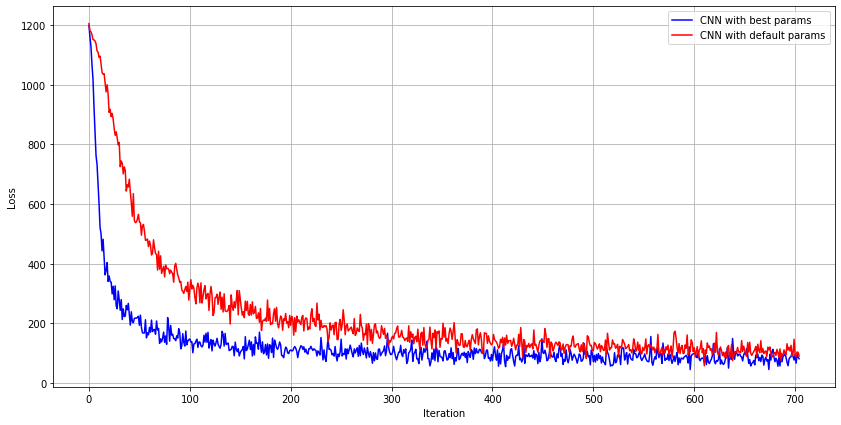

In [37]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(logs, label = "CNN with best params", color = "b")
ax.plot(log1, label = "CNN with default params", color = "r")
ax.legend()
ax.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [39]:
print(acc, acc1)

0.9798333333333333 0.974
